In [1]:
!pip install ipyleaflet
!pip install osmnx #OpenStreetMap, umozliwia dostep do siatki drog
!pip install networkx #pomaga w tworzeniu grafow, na przyklad z drog
!pip install numpy
!pip install osmnx geopandas #rozszerzenie klasycznego pandas ale do danych przestrzennych
!pip install --upgrade osmnx
!pip install osmnx geopandas --quiet

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 100.5/100.5 kB 2.2 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import networkx as nx
import folium #wizualizacja na mapie
from folium.plugins import AntPath #interaktywna mapa i animacja trasy
import random #losowanie tras, mutacji, punkt√≥w start/meta
import numpy as np
import matplotlib.pyplot as plt#wizualizacja grafu (statycznie ‚Äì nie na mapie) ox.settings.use_cache = True #osmnx bƒôdzie zapisywa≈Ç dane lokalnie (nie pobiera ponownie)
import osmnx as ox
from folium.plugins import AntPath
from IPython.display import display, clear_output
from ipyleaflet import Map, Marker
from ipywidgets import Output
import itertools

Algorytm zostanie uruchomiony na drogach znajdujƒÖcych siƒô w promieniu 20km od Rynku G≈Ç√≥wnego w Krakowie.

Pobieramy graf zawierajƒÖcy krawƒôdzie, kt√≥re reprezentujƒÖ drogi oraz wierzcho≈Çki, kt√≥re reprezentujƒÖ ko≈Ñce dr√≥g, skrzy≈ºowania itd.


Pobieranie grafu dr√≥g w promieniu 10 km od centrum Krakowa...
Wy≈õwietlanie grafu wƒôz≈Ç√≥w i krawƒôdzi...


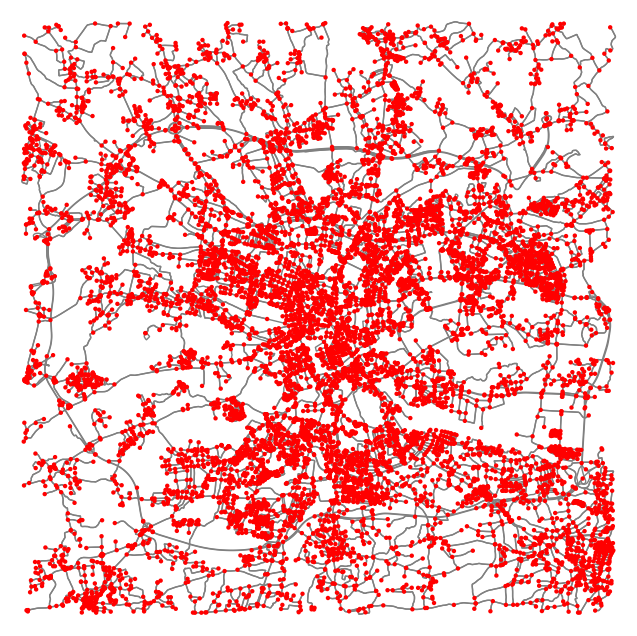

In [3]:
ox.settings.log_console = True #logi beda wyswietlane w konsoli

center_point = (50.06143, 19.93658)  # Rynek G≈Ç√≥wny, Krak√≥w
distance = 10000  # 10 km

print("Pobieranie grafu dr√≥g w promieniu 10 km od centrum Krakowa...")
G = ox.graph_from_point(center_point, dist=distance, network_type='drive') #tylko drogi przejezdne dla samochodow

print("Wy≈õwietlanie grafu wƒôz≈Ç√≥w i krawƒôdzi...")
fig, ax = ox.plot_graph(G, node_size=10, node_color='red', edge_color='gray', edge_linewidth=1, bgcolor='white')


Konwersja grafu na GeoDataFrame krawƒôdzi...
Unikalne typy dr√≥g w krawƒôdziach:
['secondary' 'tertiary' 'residential' 'primary' 'primary_link'
 'tertiary_link' 'motorway_link' 'living_street' 'motorway' 'unclassified'
 'secondary_link' 'trunk' 'trunk_link']
Liczba krawƒôdzi po filtracji: 26565
Przywracanie grafu z przefiltrowanych krawƒôdzi...
Rysowanie grafu...


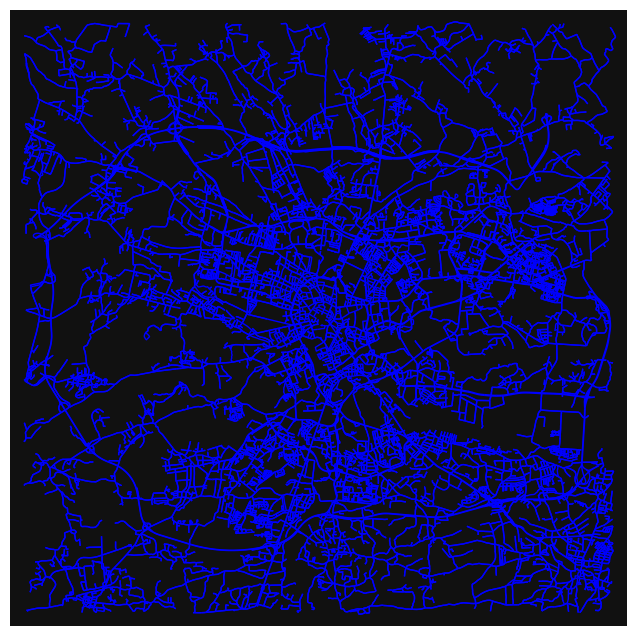

In [4]:

print("Konwersja grafu na GeoDataFrame krawƒôdzi...")
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
print("Unikalne typy dr√≥g w krawƒôdziach:")
print(edges['highway'].explode().unique())

allowed = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link','living_street','road','residential','unclassified']

def highway_filter(hw):
    if isinstance(hw, list):
        return any(h in allowed for h in hw)
    else:
        return hw in allowed

edges_filtered = edges[edges['highway'].notnull()]
edges_filtered = edges_filtered[edges_filtered['highway'].apply(highway_filter)]

print(f"Liczba krawƒôdzi po filtracji: {len(edges_filtered)}")

if len(edges_filtered) == 0:
    print("Brak krawƒôdzi po filtracji. U≈ºywam pe≈Çnego grafu bez filtrowania.")
    edges_filtered = edges

print("Przywracanie grafu z przefiltrowanych krawƒôdzi...")
G_filtered = ox.graph_from_gdfs(nodes, edges_filtered)

print("Rysowanie grafu...")
fig, ax = ox.plot_graph(G_filtered, node_size=0, edge_color='blue', edge_linewidth=1)

Funkcja fitness(route) zwraca nam d≈Çugo≈õƒá trasy je≈õli trasa istnieje lub niesko≈Ñczono≈õc je≈õli trasa nie istnieje.

In [5]:
def fitness(route, graph):
    if route is None or not is_valid_route(route, graph):
        return float('inf')
    total_length = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if graph.has_edge(u, v):
            # W MultiDiGraph mo≈ºe byƒá wiele krawƒôdzi, wybieramy pierwszƒÖ
            edge_data = list(graph[u][v].values())[0]
            total_length += edge_data.get('length', float('inf'))
        else:
            return float('inf')  # brak krawƒôdzi = niepoprawna trasa
    return total_length

Funkcja random route znajduje losowƒÖ trasƒô. Funkcja idzie od wƒôz≈Ça start i nastƒôpnie wybiera losowy wƒôze≈Ç, kt√≥ry jest z nim po≈ÇƒÖczony, a≈º nie dojdzie do wƒôz≈Ça end (lub wykona max_attempts iteracji).

In [6]:
def random_route(graph, start, end, max_attempts=5000):
    for _ in range(max_attempts):
        current = start
        route = [current]
        visited = set()
        while current != end:
            visited.add(current)
            try:
                neighbors = [n for n in graph.successors(current) if n not in visited]
            except nx.NetworkXError:
                break  # Wezel nie istnieje w grafie

            if not neighbors:
                break  # Slepy zaulek

            current = random.choice(neighbors)
            route.append(current)

        if current == end:
            return route
    return None  # Nie uda≈Ço sie znalezc trasy

Sprawdza, czy wszystkie kolejne wierzcho≈Çki w trasie sƒÖ po≈ÇƒÖczone krawƒôdziami w grafie.

In [7]:
def is_valid_route(route, graph):
    if route is None:
        return False
    return all(graph.has_edge(route[i], route[i+1]) for i in range(len(route) - 1))


Funkcja crossover ≈ÇƒÖczy dwie trasy w jednƒÖ.

Najpierw wybiera wƒôze≈Ç, kt√≥ry nale≈ºy zar√≥wno do pierwszej trasy jak i do drugiej, aby nastƒôpnie 'uciƒÖƒá' w nim obie trasy. Odcinek [start,wƒôze≈Ç] z pierwszej trasy jest sklajeny z odcinkiem [wƒôze≈Ç, end] z drugiej trasy, w skutek czego powstaje nowa trasa.

In [9]:
def crossover(parent1, parent2, graph):
    common_nodes = set(parent1[1:-1]) & set(parent2[1:-1])
    if not common_nodes:
        return None

    for _ in range(2):
        crossover_node = random.choice(list(common_nodes))
        i1 = parent1.index(crossover_node)
        i2 = parent2.index(crossover_node)

        child = parent1[:i1] + parent2[i2:]
        if is_valid_route(child, graph):
            return child
    return None

Funkcja mutate modyfikuje istniejƒÖcƒÖ trasƒô z pewnym prawdopodobie≈Ñstwem (mutation_rate).

Robi to tak, ≈ºe wybiera dwa indeksy i, j nalezace do zadanej trasy a nastƒôpnie szuka najkr√≥tszej ≈õcie≈ºki miƒôdzy tymi punktami w grafie. Je≈õli znajdzie takƒÖ ≈õcie≈ºkƒô to zastƒôpuje niƒÖ odcinek miƒôdzy punktami i oraz j.


Algorytm genetyczny ale tylko na potrzeby funkcji mutate, w≈Ça≈õciwy znajduje siƒô ni≈ºej

In [18]:
def genetic_alg_for_mutate(G, start, end, population_size=30, generations=5):
    population = [random_route(G, start, end) for _ in range(population_size)]
    population = [route for route in population if route is not None]

    if not population:
        return None

    population = sorted(population, key=lambda r: fitness(r, G))
    best = population[0]

    for gen in range(1, generations + 1):
        population = sorted(population, key=lambda r: fitness(r, G))
        next_gen = population[:4]

        while len(next_gen) < population_size:
            if random.random() < 0.2:
                new_route = random_route(G, start, end)
                if new_route is not None:
                    next_gen.append(new_route)
                continue

            parent1, parent2 = random.choices(population[:40], k=2)
            if parent1 is None or parent2 is None:
                continue

            child = crossover(parent1, parent2, G)
            if child is not None:
                next_gen.append(child)

        population = sorted(next_gen, key=lambda r: fitness(r, G))
        new_best = population[0]

        if fitness(new_best, G) < fitness(best, G):
            best = new_best

    return best if fitness(best, G) != float('inf') else None


In [19]:
def mutate(route, graph, mutation_rate=0.4):
    if route is None or len(route) < 4 or random.random() > mutation_rate:
        return route

    for _ in range(5):
        i = random.randint(1, len(route) - 3)
        j = random.randint(i + 1, len(route) - 2)

        sub_path = genetic_alg_for_mutate(graph, route[i], route[j], population_size=10, generations=4)
        if sub_path is None or len(sub_path) < 2:
            continue

        new_route = route[:i] + sub_path + route[j + 1:]
        if is_valid_route(new_route, graph):
            return new_route

    return route


Funkcja s≈Çu≈ºƒÖca do rysowania trasy na mapie.

In [21]:

def show_route_on_map(route, graph, start_node, end_node, generation=None):
    origin_point = (graph.nodes[start_node]['y'], graph.nodes[start_node]['x'])
    destination_point = (graph.nodes[end_node]['y'], graph.nodes[end_node]['x'])
    midpoint = ((origin_point[0] + destination_point[0]) / 2,
                (origin_point[1] + destination_point[1]) / 2)

    m = folium.Map(location=midpoint, zoom_start=13)

    route_coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in route] #Tworzy liste wspolrzednych kolejnych punktow
    AntPath(route_coords, color='blue', weight=5, delay=100).add_to(m) #Dodaje animowana linie (AntPath) na mapie

    folium.Marker(origin_point, tooltip="Start", icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(destination_point, tooltip="Meta", icon=folium.Icon(color='red')).add_to(m)

    if generation is not None:
        title_html = f'''
             <h4 align="center" style="font-size:16px"><b>Najlepsza trasa - Generacja {generation}</b></h4>
             '''
        m.get_root().html.add_child(folium.Element(title_html))

    clear_output(wait=True)
    display(m)

D≈Çugo≈õƒá trasy.

G≈Ç√≥wna funkcja optymalizacji ‚Äì szuka najlepszej trasy metodƒÖ genetycznƒÖ.

Dzia≈Çanie:

Algorytm najpierw generuje population_size losowych tras miƒôdzy poczƒÖtkiem a ko≈Ñcem trasy. Nastƒôpnie wybiera najkr√≥tszƒÖ z nich i tym ko≈Ñczy generacjƒô 0.

Nastƒôpnie algorytm przechodzi do kolejnych generacji, czyli teraz bƒôdzie poprawia≈Ç uzyskanƒÖ trasƒô.

Do ka≈ºdej kolejnej generacji przechodzƒÖ 4 najlepsze trasy z poprzedniej.

Z prawdopodobie≈Ñstwem 20% do nastƒôpnej generacji zostanie te≈º dodana losowa, nowa trasa.

R√≥wnie≈º dwie losowe trasy spo≈õr√≥d 40 najlepszych sƒÖ krzy≈ºowane ze sobƒÖ i dodawane do kolejnej generacji.

Ka≈ºda nowa generacja jest sortowana, populacja siƒô uaktualnia i jest wy≈Çaniany lider, kt√≥ry por√≥wnywany jest do lidera poprzedniej generacji.

In [23]:
def genetic_algorithm(G, start, end, population_size=75, generations=15):
    try:
        dijkstra_path = nx.shortest_path(G, start, end, weight='length')
        dijkstra_length = fitness(dijkstra_path, G)
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        print("Nie mo≈ºna wyznaczyƒá najkr√≥tszej trasy Dijkstry.") #nie istnieje droga miedzy start a meta
        return None

    population = [random_route(G, start, end) for _ in range(population_size)]
    population = [route for route in population if route is not None]

    if not population:
        return None, []
    population = sorted(population, key=lambda r: fitness(r, G))
    best = population[0]
    show_route_on_map(best, G, start, end, generation=0)

    accuracy_per_generation = [] #do wykresu
    for gen in range(1, generations + 1):
        population = sorted(population, key=lambda r: fitness(r, G))
        next_gen = population[:4]

        while len(next_gen) < population_size:
            if random.random() < 0.2:
                new_route = random_route(G, start, end)
                if new_route is not None:
                    next_gen.append(new_route)
                continue

            parent1, parent2 = random.choices(population[:40], k=2)
            if parent1 is None or parent2 is None:
                continue

            child = crossover(parent1, parent2, G)
            if child is None:
                continue

            child = mutate(child, G)
            if child is not None:
                next_gen.append(child)

        population = sorted(next_gen, key=lambda r: fitness(r, G))
        new_best = population[0]

        if fitness(new_best, G) < fitness(best, G):
            best = new_best
            print(f"Generacja {gen}: Nowa najlepsza trasa, d≈Çugo≈õƒá = {fitness(best, G):.2f} m")
            show_route_on_map(best, G, start, end, generation=gen)

        best_length = fitness(best, G)
        if best_length != float('inf') and dijkstra_length != 0:
            accuracy = (dijkstra_length / best_length) * 100
        else:
            accuracy = 0.0
        accuracy_per_generation.append((gen, accuracy))
    if fitness(best, G) == float('inf'):
        return None, accuracy_per_generation
    else:
        return best, accuracy_per_generation


In [24]:
num_waypoints = int(input("Ile punkt√≥w po≈õrednich chcesz odwiedziƒá? "))

Ile punkt√≥w po≈õrednich chcesz odwiedziƒá? 3


In [25]:

out = Output()

clicked_nodes = []
waypoint_nodes = []
markers = []
origin_node = None
destination_node = None

if nx.is_strongly_connected(G_filtered):
    G_sub = G_filtered
else:
    # spojne komponenty dla skierowanego grafu
    largest_scc = max(nx.strongly_connected_components(G_filtered), key=len)
    G_sub = G_filtered.subgraph(largest_scc).copy()

valid_nodes = list(G_sub.nodes)


def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')
        nearest_node = ox.distance.nearest_nodes(G_sub, X=lon, Y=lat)

        if nearest_node not in valid_nodes:
            with out:
                print("‚ö†Ô∏è Punkt poza grafem ‚Äì wybierz inny.")
            return

        clicked_nodes.append(nearest_node)
        marker = Marker(location=(lat, lon))
        m.add_layer(marker)
        markers.append(marker)

        idx = len(clicked_nodes)
        if idx == 1:
            with out:
                print("‚úÖ START wybrany.")
        elif 1 < idx <= num_waypoints + 1:
            with out:
                print(f"üü° Dodano punkt po≈õredni ({idx - 2 + 1}/{num_waypoints})")
        elif idx == num_waypoints + 2:
            with out:
                print("‚úÖ META wybrana.")
                global origin_node, destination_node, waypoint_nodes
                origin_node = clicked_nodes[0]
                destination_node = clicked_nodes[-1]
                waypoint_nodes = clicked_nodes[1:-1]
                print("‚úÖ Wszystkie punkty wybrane. Mo≈ºesz uruchomiƒá algorytm.")

m = Map(center=center_point, zoom=14)
m.on_interaction(handle_map_click)

display(m)
display(out)   # Wybierz najwiƒôkszy sp√≥jny komponent grafu (na potrzeby wyznaczania tras)

while destination_node == origin_node:
    destination_node = random.choice(valid_nodes)

print(f"Wylosowano punkty: start={origin_node}, meta={destination_node}")


Map(center=[50.06143, 19.93658], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '‚Ä¶

Output()

Wylosowano punkty: start=None, meta=749934314


In [27]:
route_cache = {}
min_route = None
min_length = float('inf')
all_accuracies = []
all_accuracy_plots = []


for perm in itertools.permutations(waypoint_nodes):
    candidate_nodes = [origin_node] + list(perm) + [destination_node]
    candidate_route = []
    valid = True

    for i in range(len(candidate_nodes) - 1):
        a, b = candidate_nodes[i], candidate_nodes[i + 1]

        if (a, b) in route_cache:
            sub_route = route_cache[(a, b)]
        elif (b, a) in route_cache:
            sub_route = route_cache[(b, a)][::-1]
        else:
            sub_route, acc = genetic_algorithm(G_sub, a, b,population_size=120, generations=10)
            if acc:
                all_accuracy_plots.append({
                    "a": a,
                    "b": b,
                    "gens": [g for g, _ in acc],
                    "accs": [a for _, a in acc]
                })


            if sub_route is not None:
                route_cache[(a, b)] = sub_route

        if sub_route is None:
            valid = False
            break
        if i > 0:
            sub_route = sub_route[1:]  # unikamy powtorzenia wezlow
        candidate_route.extend(sub_route)

    if valid:
        length = fitness(candidate_route, G_filtered)
        if length < min_length:
            min_length = length
            min_route = candidate_route
            optimal_order = candidate_nodes #najlepsza kolejnosc
if min_route is None:
    print("Nie uda≈Ço siƒô znale≈∫ƒá ≈ºadnej sp√≥jnej trasy.")
    full_route = None
else:
#RYSOWANIE WYKRESU
# else:
#     for plot_data in all_accuracy_plots:
#         plt.figure(figsize=(10, 5))
#         plt.plot(plot_data["gens"], plot_data["accs"], marker='o')
#         plt.xlabel("Generacja")
#         plt.ylabel("Dok≈Çadno≈õƒá [%]")
#         plt.title(f"Dok≈Çadno≈õƒá trasy {plot_data['a']} ‚Üí {plot_data['b']} w ka≈ºdej generacji")
#         plt.grid()
#         plt.show()


    full_route = min_route
    all_nodes = optimal_order
    print(f"Znaleziono optymalnƒÖ trasƒô o d≈Çugo≈õci: {min_length:.2f} metr√≥w")


    dijkstra_route = []
    valid_dijkstra = True

    for i in range(len(all_nodes) - 1):
        a, b = all_nodes[i], all_nodes[i + 1]
        try:
            sub_path = nx.shortest_path(G_filtered, source=a, target=b, weight='length')
            if i > 0:
                sub_path = sub_path[1:]  # unikaj powt√≥rze≈Ñ
            dijkstra_route.extend(sub_path)
        except nx.NetworkXNoPath:
            valid_dijkstra = False
            print(f"Brak ≈õcie≈ºki miƒôdzy {a} a {b}")
            break

    if valid_dijkstra:
        dijkstra_length = fitness(dijkstra_route, G_filtered)
        print(f"D≈Çugo≈õƒá trasy NetworkX (dijkstra): {dijkstra_length:.2f} metr√≥w")
        print(f"D≈Çugo≈õƒá trasy z algorytmu genetycznego: {min_length:.2f} metr√≥w")
        print(f"R√≥≈ºnica d≈Çugo≈õci: {min_length - dijkstra_length:.2f} metr√≥w")
    else:
        print("Nie uda≈Ço siƒô wyznaczyƒá trasy Dijkstry dla zadanych punkt√≥w.")


    midpoint = ((G_filtered.nodes[origin_node]['y'] + G_filtered.nodes[destination_node]['y']) / 2,
                (G_filtered.nodes[origin_node]['x'] + G_filtered.nodes[destination_node]['x']) / 2)
    if valid_dijkstra:
        dijkstra_coords = [(G_filtered.nodes[n]['y'], G_filtered.nodes[n]['x']) for n in dijkstra_route]
    else:
        dijkstra_coords = []

    m = folium.Map(location=midpoint, zoom_start=13)

    # Trasa
    coords = [(G_filtered.nodes[n]['y'], G_filtered.nodes[n]['x']) for n in full_route]
    AntPath(coords, color='blue', weight=5, delay=100).add_to(m)
    # Dodanie trasy Dijkstry w innym kolorze, np. czerwonym
    if dijkstra_coords:
        AntPath(dijkstra_coords, color='red', weight=3, delay=100).add_to(m)

    # Markery
    folium.Marker(location=(G_filtered.nodes[origin_node]['y'], G_filtered.nodes[origin_node]['x']),
                  tooltip="Start", icon=folium.Icon(color='green')).add_to(m)

    for i, wp in enumerate(waypoint_nodes, 1):
      folium.Marker(
          location=(G_filtered.nodes[wp]['y'], G_filtered.nodes[wp]['x']),
          tooltip=f"Po≈õredni {i}",
          icon=folium.Icon(color='orange', icon='info-sign')
      ).add_to(m)


    folium.Marker(location=(G_filtered.nodes[destination_node]['y'], G_filtered.nodes[destination_node]['x']),
                  tooltip="Meta", icon=folium.Icon(color='red')).add_to(m)

    m.save("mapa_trasa_krakow.html")
    from google.colab import files
    files.download("mapa_trasa_krakow.html")


Znaleziono optymalnƒÖ trasƒô o d≈Çugo≈õci: 8008.97 metr√≥w
D≈Çugo≈õƒá trasy NetworkX (dijkstra): 8008.97 metr√≥w
D≈Çugo≈õƒá trasy z algorytmu genetycznego: 8008.97 metr√≥w
R√≥≈ºnica d≈Çugo≈õci: 0.00 metr√≥w


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------------------------------------------------------------TEST------------------------------------------------------------------------------------------------------------

In [ ]:

out = Output()
clicked_nodes = []
waypoint_nodes = []
markers = []
origin_node = None
destination_node = None
num_waypoints = 0

if nx.is_strongly_connected(G_filtered):
    G_sub = G_filtered
else:
    largest_scc = max(nx.strongly_connected_components(G_filtered), key=len)
    G_sub = G_filtered.subgraph(largest_scc).copy()

valid_nodes = list(G_sub.nodes)

def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')
        nearest_node = ox.distance.nearest_nodes(G_sub, X=lon, Y=lat)

        if nearest_node not in valid_nodes:
            with out:
                print("‚ö†Ô∏è Punkt poza grafem ‚Äì wybierz inny.")
            return

        clicked_nodes.append(nearest_node)
        marker = Marker(location=(lat, lon))
        m.add_layer(marker)
        markers.append(marker)

        idx = len(clicked_nodes)
        if idx == 1:
            with out:
                print("‚úÖ START wybrany.")
        elif 1 < idx <= num_waypoints + 1:
            with out:
                print(f"üü° Dodano punkt po≈õredni ({idx - 2 + 1}/{num_waypoints})")
        elif idx == num_waypoints + 2:
            with out:
                print("‚úÖ META wybrana.")
                global origin_node, destination_node, waypoint_nodes
                origin_node = clicked_nodes[0]
                destination_node = clicked_nodes[-1]
                waypoint_nodes = clicked_nodes[1:-1]
                print("‚úÖ Wszystkie punkty wybrane. Mo≈ºesz uruchomiƒá algorytm.")

m = Map(center=center_point, zoom=14)
m.on_interaction(handle_map_click)

display(m)
display(out)



Map(center=[50.06143, 19.93658], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '‚Ä¶

Output()

Populacja 200 ‚Üí d≈Çugo≈õƒá: 4602.58 m ‚Üí dok≈Çadno≈õƒá: 93.75%


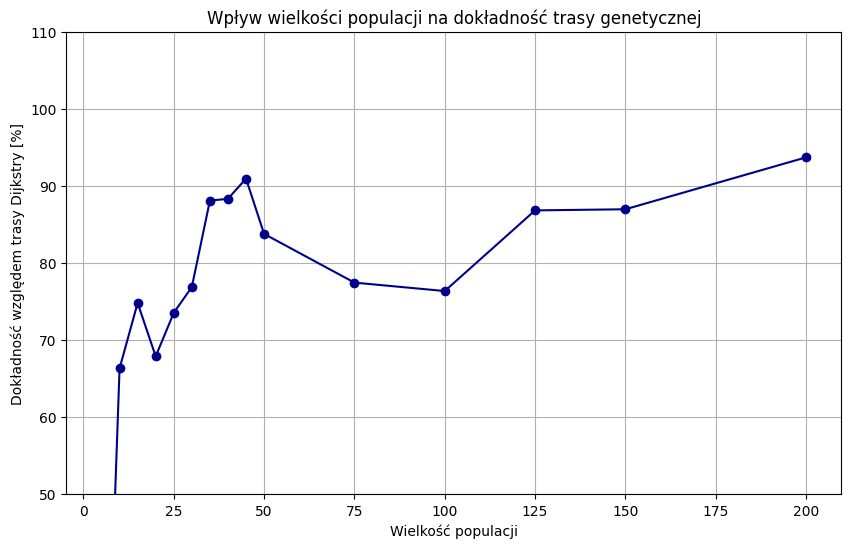

In [ ]:
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker
from IPython.display import display
from ipywidgets import Output
import networkx as nx
import itertools

out = Output()
clicked_nodes = []
waypoint_nodes = []
markers = []
origin_node = None
destination_node = None
num_waypoints = 0

if nx.is_strongly_connected(G_filtered):
    G_sub = G_filtered
else:
    largest_scc = max(nx.strongly_connected_components(G_filtered), key=len)
    G_sub = G_filtered.subgraph(largest_scc).copy()

valid_nodes = list(G_sub.nodes)


origin_node, destination_node = 1755264037,280888490


def run_population_experiment():
    global origin_node, destination_node, waypoint_nodes
    if not (origin_node and destination_node):
        print("‚ö†Ô∏è Musisz wybraƒá punkty na mapie.")
        return

    try:
        dijkstra_path = nx.shortest_path(G_sub, origin_node, destination_node, weight='length')
        dijkstra_length = fitness(dijkstra_path, G_sub)
    except nx.NetworkXNoPath:
        print("‚ùå Nie mo≈ºna wyznaczyƒá trasy Dijkstry miƒôdzy wybranymi punktami.")
        return

    population_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 125, 150, 200]
    accuracy_results = []

    for pop_size in population_sizes:
        print(f"\nTestowanie dla populacji: {pop_size}")
        route_cache = {}
        min_length_test = float('inf')

        for perm in itertools.permutations(waypoint_nodes):
            candidate_nodes = [origin_node] + list(perm) + [destination_node]
            candidate_route = []
            valid = True

            for i in range(len(candidate_nodes) - 1):
                a, b = candidate_nodes[i], candidate_nodes[i + 1]

                if (a, b) in route_cache:
                    sub_route = route_cache[(a, b)]
                elif (b, a) in route_cache:
                    sub_route = route_cache[(b, a)][::-1]
                else:
                    sub_route, _ = genetic_algorithm(G_sub, a, b, population_size=pop_size, generations=1)
                    if sub_route is not None:
                        route_cache[(a, b)] = sub_route

                if sub_route is None:
                    valid = False
                    break

                if i > 0:
                    sub_route = sub_route[1:]
                candidate_route.extend(sub_route)

            if valid:
                length = fitness(candidate_route, G_filtered)
                if length < min_length_test:
                    min_length_test = length

        if min_length_test < float('inf'):
            accuracy = dijkstra_length / min_length_test * 100
            accuracy_results.append((pop_size, accuracy))
            print(f"Populacja {pop_size} ‚Üí d≈Çugo≈õƒá: {min_length_test:.2f} m ‚Üí dok≈Çadno≈õƒá: {accuracy:.2f}%")
        else:
            accuracy_results.append((pop_size, 0))
            print(f"Populacja {pop_size} ‚Üí NIE ZNALEZIONO trasy.")

    x_vals, y_vals = zip(*accuracy_results)
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='darkblue')
    plt.title("Wp≈Çyw wielko≈õci populacji na dok≈Çadno≈õƒá trasy genetycznej")
    plt.xlabel("Wielko≈õƒá populacji")
    plt.ylabel("Dok≈Çadno≈õƒá wzglƒôdem trasy Dijkstry [%]")
    plt.ylim(50, 110)
    plt.grid(True)
    plt.show()

run_population_experiment()
